In [84]:
import pandas as pd

urlstops = 'https://raw.githubusercontent.com/dustinhodges/DS-Unit-2-Applied-Modeling/master/MplsStops.csv'
urldemo = 'https://raw.githubusercontent.com/dustinhodges/DS-Unit-2-Applied-Modeling/master/MplsDemo.csv'

stops = pd.read_csv(urlstops)
demo = pd.read_csv(urldemo)
print(stops.shape, demo.shape)

minn = pd.merge(stops, demo, how='outer', on='neighborhood')

print(minn.shape)


(51920, 15) (84, 9)
(51920, 23)


In [85]:
'''
'outcome', 
a newly engineered column will be our target. 
First we will clean three other columns in order to combine them:
'''

minn[['citationIssued',
      'personSearch',
      'vehicleSearch']] = minn[['citationIssued',
                                'personSearch',
                                'vehicleSearch']].fillna('Unknown')

end = minn['citationIssued'] + minn['personSearch'] + minn['vehicleSearch']
minn['outcome'] = end

minn['outcome'].value_counts()

UnknownNONO              21406
NONONO                   13805
UnknownUnknownUnknown     8221
YESNONO                   2662
UnknownYESYES             1452
UnknownYESNO              1422
NOYESNO                   1076
NOYESYES                   828
UnknownNOYES               309
YESYESYES                  251
YESYESNO                   208
NONOYES                    190
YESNOYES                    90
Name: outcome, dtype: int64

In [86]:
'''
minn.outcome = minn.outcome.replace({"UnknownNONO": "none",
                                     "NONONO": "none",
                                     "UnknownUnknownUnknown": "unknown",
                                     "YESNONO": "citation",
                                     "UnknownYESYES": "search",
                                     "UnknownYESNO": "search",
                                     "NOYESNO": "search",
                                     "NOYESYES": "search",
                                     "UnknownNOYES": "search",
                                     "YESYESYES": "search + citation",
                                     "YESYESNO": "search + citation",
                                     "NONOYES": "search",
                                     "YESNOYES": "search + citation"}
                                   ) 
'''

minn.outcome = minn.outcome.replace({"UnknownNONO":"other",
                                     "NONONO":"other",
                                     "UnknownUnknownUnknown": "other",
                                     "YESNONO":               "search|citation",
                                     "UnknownYESYES":         "search|citation",
                                     "UnknownYESNO":          "search|citation",
                                     "NOYESNO":               "search|citation",
                                     "NOYESYES":              "search|citation",
                                     "UnknownNOYES":          "search|citation",
                                     "YESYESYES":             "search|citation",
                                     "YESYESNO":              "search|citation",
                                     "NONOYES":               "search|citation",
                                     "YESNOYES":              "search|citation"}
                                   ) 

minn['outcome'].value_counts()

other              43432
search|citation     8488
Name: outcome, dtype: int64

All unknowns come from no MDC

'outcome' has 5 discrete classes: 
none, unknown, search, citation, search + citation.

'none' occurs 68% of the time. 'search + citation' occurs 1% of the time.

[ ] Choose which observations you will use to train, validate, and test your model.
Are some observations outliers? Will you exclude them?
Will you do a random split or a time-based split?

There are no 'outliers' in this case with the possible exception of 'unknown' values where presumably the data was not recorded by police officers. We will not exclude them because we want our app to handle incomplete input information.
I will use a random split for train, test, validation.

[ ] Choose your evaluation metric(s).
Classification: Is your majority class frequency > 50% and < 70% ? If so, you can just use accuracy if you want. Outside that range, accuracy could be misleading. What evaluation metric will you choose, in addition to or instead of accuracy?

I can use accuracy but I'll also want to explore precision and recall for certain classes. For example, predicting a particular outcome for a particular demographic etc could be "false alarm" or "failure to warn". Must decide which is worse...

In [43]:
minn.head()

,Unnamed: 0_x,idNum,date,problem,MDC,citationIssued,personSearch,vehicleSearch,preRace,race,...,neighborhood,Unnamed: 0_y,population,white,black,foreignBorn,hhIncome,poverty,collegeGrad,outcome
0,6823,17-000003,2017-01-01 00:00:42,suspicious,MDC,Unknown,NO,NO,Unknown,Unknown,...,Cedar Riverside,1.0,8247.0,0.353,0.464,0.408,18892.0,0.06,0.258,none
1,6834,17-000161,2017-01-01 01:15:01,traffic,other,Unknown,Unknown,Unknown,NaN,NaN,...,Cedar Riverside,1.0,8247.0,0.353,0.464,0.408,18892.0,0.06,0.258,other
2,6909,17-001251,2017-01-01 23:45:15,traffic,other,Unknown,Unknown,Unknown,NaN,NaN,...,Cedar Riverside,1.0,8247.0,0.353,0.464,0.408,18892.0,0.06,0.258,other
3,6992,17-002190,2017-01-02 21:46:12,suspicious,MDC,Unknown,NO,NO,White,White,...,Cedar Riverside,1.0,8247.0,0.353,0.464,0.408,18892.0,0.06,0.258,none
4,7134,17-003851,2017-01-04 09:06:24,traffic,other,Unknown,Unknown,Unknown,NaN,NaN,...,Cedar Riverside,1.0,8247.0,0.353,0.464,0.408,18892.0,0.06,0.258,other


visualizations, 

[ ] Begin to choose which features, if any, to exclude. Would some features "leak" future information?

In [87]:
import numpy as np
from sklearn.model_selection import train_test_split

train = minn.copy()
train, test = train_test_split(train, train_size=0.80, test_size=0.20,
                               stratify=train['outcome'], random_state=42)
train, val = train_test_split(train, train_size=0.80, test_size=0.20,
                             stratify=train['outcome'], random_state=42)

train.shape, val.shape, test.shape

((33228, 24), (8308, 24), (10384, 24))

In [88]:
def wrangle(X):
    
    X = X.copy()
    
    X[['race_MISSING']] = X[['race']].isnull()
    X[['gender_MISSING']] = X[['gender']].isnull()

    unusable_variance = ['Unnamed: 0_x', 'idNum','citationIssued',
                         'personSearch', 'vehicleSearch', 'Unnamed: 0_y']
    X = X.drop(columns=unusable_variance)
    
    X['date'] = pd.to_datetime(X['date'], infer_datetime_format=True)
    
    X['month'] = X['date'].dt.month
    X['day'] = X['date'].dt.day
    X['hour'] = X['date'].dt.hour
    X = X.drop(columns='date')
    
    X['race_confusion'] = (X['race'] != X['preRace'])
    
    return X

train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

train.shape, val.shape, test.shape

((33228, 23), (8308, 23), (10384, 23))


engineer:

race of neighborhood, demographics etc...
racialconfusion,

string encode policePrecinct


In [89]:
target = 'outcome'

X_train = train.drop(columns=target)
y_train = train[target]
X_val = val.drop(columns=target)
y_val = val[target]
X_test = test.drop(columns=target)
y_test = test[target]

In [47]:
unknown = pd.DataFrame(train[train['outcome']=='unknown'])

In [48]:
def no_outcome(col):
    print(unknown[col].value_counts())
    print(train[col].value_counts())
    
no_outcome('policePrecinct')

Series([], Name: policePrecinct, dtype: int64)
5    8307
4    7878
3    6170
2    6047
1    4826
Name: policePrecinct, dtype: int64


In [49]:
train.head()

,problem,MDC,preRace,race,gender,lat,long,policePrecinct,neighborhood,population,...,hhIncome,poverty,collegeGrad,outcome,race_MISSING,gender_MISSING,month,day,hour,race_confusion
19775,suspicious,MDC,Unknown,Black,Male,44.952796,-93.318830,5,Cedar - Isles - Dean,2984.0,...,118750.0,0.089,0.758,none,False,False,3,4,22,True
32021,suspicious,other,NaN,NaN,NaN,44.974000,-93.285580,1,Loring Park,8262.0,...,37438.0,0.060,0.623,other,True,True,7,3,19,True
14254,suspicious,MDC,Unknown,Black,Male,45.007840,-93.315880,4,Willard - Hay,9074.0,...,44733.0,0.048,0.269,none,False,False,5,17,14,True
36199,traffic,MDC,Unknown,Black,Male,44.948350,-93.271600,3,Central,8618.0,...,42856.0,0.053,0.264,none,False,False,1,25,19,True
45833,traffic,MDC,Unknown,Black,Male,45.032532,-93.247231,2,Waite Park,5362.0,...,73477.0,0.055,0.463,none,False,False,3,21,22,True


In [52]:
no_MDC.head()

,problem,MDC,preRace,race,gender,lat,long,policePrecinct,neighborhood,population,...,hhIncome,poverty,collegeGrad,outcome,race_MISSING,gender_MISSING,month,day,hour,race_confusion
32021,suspicious,other,NaN,NaN,NaN,44.974000,-93.285580,1,Loring Park,8262.0,...,37438.0,0.060,0.623,other,True,True,7,3,19,True
11656,traffic,other,NaN,NaN,NaN,45.016790,-93.300640,4,Folwell,5023.0,...,40442.0,0.103,0.181,other,True,True,4,18,3,True
2227,suspicious,other,NaN,NaN,NaN,44.980833,-93.271960,1,Downtown West,7141.0,...,67086.0,0.057,0.551,other,True,True,4,29,0,True
10029,traffic,other,NaN,NaN,NaN,44.979940,-93.234410,2,Marcy Holmes,10496.0,...,27104.0,0.042,0.587,other,True,True,10,19,22,True
23887,traffic,other,NaN,NaN,NaN,44.946603,-93.282199,5,Lyndale,7441.0,...,38441.0,0.083,0.390,other,True,True,4,19,0,True


In [57]:
no_MDC = pd.DataFrame(train[train['MDC']=='other'])

In [60]:
def other_MDC(col):
    print(no_MDC[col].value_counts())
    print(train[col].value_counts())
    
other_MDC('outcome')

other    5282
Name: outcome, dtype: int64
none     22535
other    10693
Name: outcome, dtype: int64


In [485]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier

from sklearn.pipeline import make_pipeline

pipeline1 = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

pipeline.fit(X_train, y_train)
print('Validation Accuracy', pipeline.score(X_val, y_val))

ValueError: DataFrame.dtypes for data must be int, float or bool.
                Did not expect the data types in fields preRace, neighborhood

Fit a model. Does it beat your baseline?

Our baseline is 68% 
With minimal feature engineering 
and basic RandomForestClassifier model, 
we're up to 81%. A good Start!
With date features, racial confusion, up to 84%

Unit 2, Sprint 3, Module 2
Permutation & Boosting

 
Continue to clean and explore your data. Make exploratory visualizations.
Complete Engineering with initial ideas. 

Try xgboost.
Get your model's permutation importances.



In [488]:
transformers = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='median')
)

X_train_transformed = transformers.fit_transform(X_train)
X_val_transformed = transformers.transform(X_val)

model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train_transformed, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [302]:
import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(
    model,
    scoring='accuracy',
    n_iter=5,
    random_state=42
)

permuter.fit(X_val_transformed, y_val)

PermutationImportance(cv='prefit',
                      estimator=RandomForestClassifier(bootstrap=True,
                                                       class_weight=None,
                                                       criterion='gini',
                                                       max_depth=None,
                                                       max_features='auto',
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                                                       n_estimators=100,
                                                     

In [489]:
feature_names = X_val.columns.tolist()
pd.Series(permuter.feature_importances_,
         feature_names).sort_values(ascending=False)

month             0.013385
problem           0.009076
hour              0.005513
day               0.001757
lat               0.000867
gender            0.000578
MDC               0.000506
collegeGrad       0.000361
race             -0.000048
race_MISSING     -0.000072
gender_MISSING   -0.000169
hhIncome         -0.000193
long             -0.000265
foreignBorn      -0.000626
poverty          -0.000843
policePrecinct   -0.000915
preRace          -0.001396
population       -0.001468
race_confusion   -0.001541
white            -0.001709
neighborhood     -0.001805
black            -0.002022
dtype: float64

In [490]:
feature_names = X_val.columns.tolist()

eli5.show_weights(
    permuter,
    top=None, # show permutation importances for all features
    feature_names=feature_names
)

Weight,Feature
0.0134 ± 0.0027,month
0.0091 ± 0.0022,problem
0.0055 ± 0.0027,hour
0.0018 ± 0.0026,day
0.0009 ± 0.0032,lat
0.0006 ± 0.0038,gender
0.0005 ± 0.0004,MDC
0.0004 ± 0.0018,collegeGrad
-0.0000 ± 0.0030,race
-0.0001 ± 0.0007,race_MISSING


In [491]:
print('Shape before removing features:', X_train.shape)

Shape before removing features: (33228, 22)


In [492]:
minimum_importance = -0.0003
mask = permuter.feature_importances_ > minimum_importance
features = X_train.columns[mask]
X_train = X_train[features]

In [493]:
print('Shape after removing features:', X_train.shape)

Shape after removing features: (33228, 13)


In [494]:
X_val = X_val[features]

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

# Fit on train, score on val
pipeline.fit(X_train, y_train)
print('Validation Accuracy', pipeline.score(X_val, y_val))

Validation Accuracy 1.0


removing features slightly lowered our validation

In [495]:
train['MDC'].value_counts()

MDC      27967
other     5261
Name: MDC, dtype: int64

In [314]:
from xgboost import XGBClassifier

xgb = make_pipeline(
    ce.OrdinalEncoder(), 
    XGBClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

xgb.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['problem', 'MDC', 'race', 'gender'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'problem',
                                          'data_type': dtype('O'),
                                          'mapping': traffic       1
suspicious    2
NaN          -2
dtype: int64},
                                         {'col': 'MDC', 'data_type': dtype('O'),
                                          'mapping': MDC      1
other    2
NaN     -2
dtype: int64},
                                         {'col': 'race'...
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, learning_rate=0.1,
                               max

In [315]:
from sklearn.metrics import accuracy_score
y_pred = pipeline.predict(X_val)
print('Validation Accuracy', accuracy_score(y_val, y_pred))

Validation Accuracy 0.8375060182956187


In [470]:
encoder = ce.OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)

model = XGBClassifier(
    n_estimators=1000,
    max_depth=7,
    learning_rate=0.5,
    n_jobs=-1
)

eval_set = [(X_train_encoded, y_train),
           (X_val_encoded, y_val)]

model.fit(X_train_encoded, y_train,
         eval_set=eval_set,
         eval_metric='merror',
         early_stopping_rounds=50)

[0]	validation_0-merror:0.158481	validation_1-merror:0.162855
Multiple eval metrics have been passed: 'validation_1-merror' will be used for early stopping.

Will train until validation_1-merror hasn't improved in 50 rounds.
[1]	validation_0-merror:0.157969	validation_1-merror:0.161892
[2]	validation_0-merror:0.157307	validation_1-merror:0.161531
[3]	validation_0-merror:0.155802	validation_1-merror:0.16129
[4]	validation_0-merror:0.154207	validation_1-merror:0.160448
[5]	validation_0-merror:0.153365	validation_1-merror:0.159003
[6]	validation_0-merror:0.152642	validation_1-merror:0.159364
[7]	validation_0-merror:0.152101	validation_1-merror:0.159485
[8]	validation_0-merror:0.150114	validation_1-merror:0.159605
[9]	validation_0-merror:0.14888	validation_1-merror:0.159726
[10]	validation_0-merror:0.147797	validation_1-merror:0.160448
[11]	validation_0-merror:0.146774	validation_1-merror:0.159846
[12]	validation_0-merror:0.14566	validation_1-merror:0.159846
[13]	validation_0-merror:0.1443

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.5, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=-1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

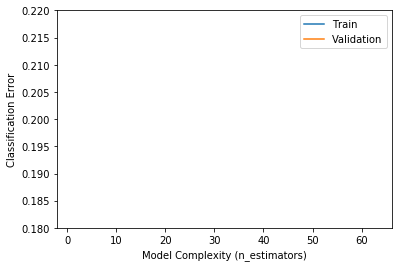

In [294]:
import matplotlib.pyplot as plt

results = model.evals_result()
train_error = results['validation_0']['merror']
val_error = results['validation_1']['merror']
epoch = range(1, len(train_error)+1)
plt.plot(epoch, train_error, label='Train')
plt.plot(epoch, val_error, label='Validation')
plt.ylabel('Classification Error')
plt.xlabel('Model Complexity (n_estimators)')
plt.ylim((0.18, 0.22)) # Zoom in
plt.legend();

Assignment
Complete these tasks for your project, and document your work.

[ ] Continue to iterate on your project: data cleaning, exploration, feature engineering, modeling.
[ ] Make at least 1 partial dependence plot to explain your model.
[ ] Share at least 1 visualization on Slack.
(If you have not yet completed an initial model yet for your portfolio project, then do today's assignment using your Tanzania Waterpumps model.)

Stretch Goals
[ ] Make multiple PDPs with 1 feature in isolation.
[ ] Make multiple PDPs with 2 features in interaction.
[ ] Use Plotly to make a 3D PDP.
[ ] Make PDPs with categorical feature(s). Use Ordinal Encoder, outside of a pipeline, to encode your data first. If there is a natural ordering, then take the time to encode it that way, instead of random integers. Then use the encoded data with pdpbox. Get readable category names on your plot, instead of integer category codes.

In [326]:
from pdpbox.pdp import pdp_interact, pdp_isolate, pdp_interact_plot

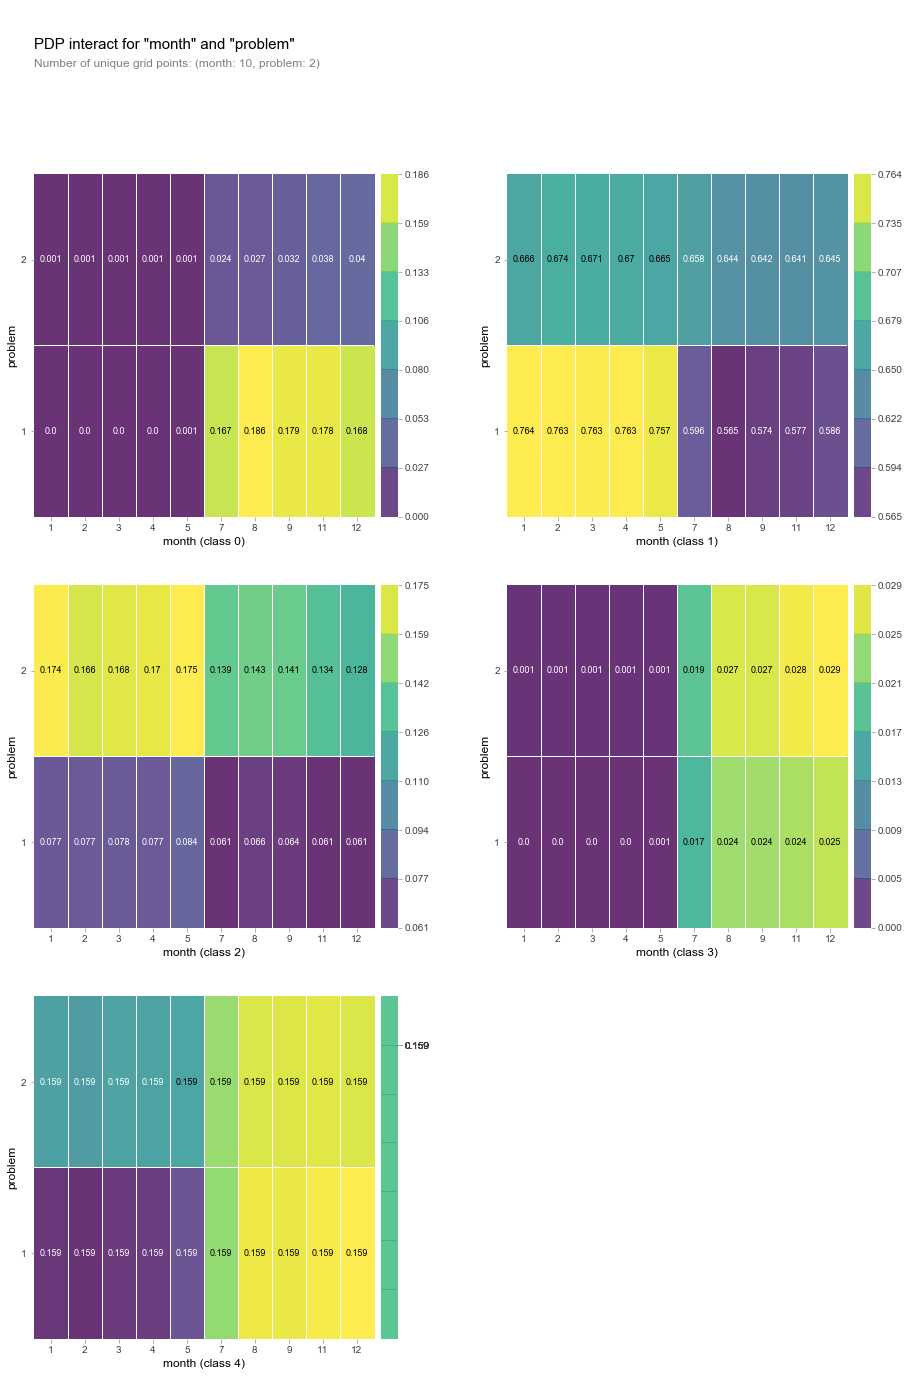

In [337]:
features = ['month', 'problem']

interaction = pdp_interact(
    model=model, 
    dataset=X_val_encoded, 
    model_features=X_val_encoded.columns, 
    features=features
)

pdp_interact_plot(interaction, plot_type='grid', feature_names=features);

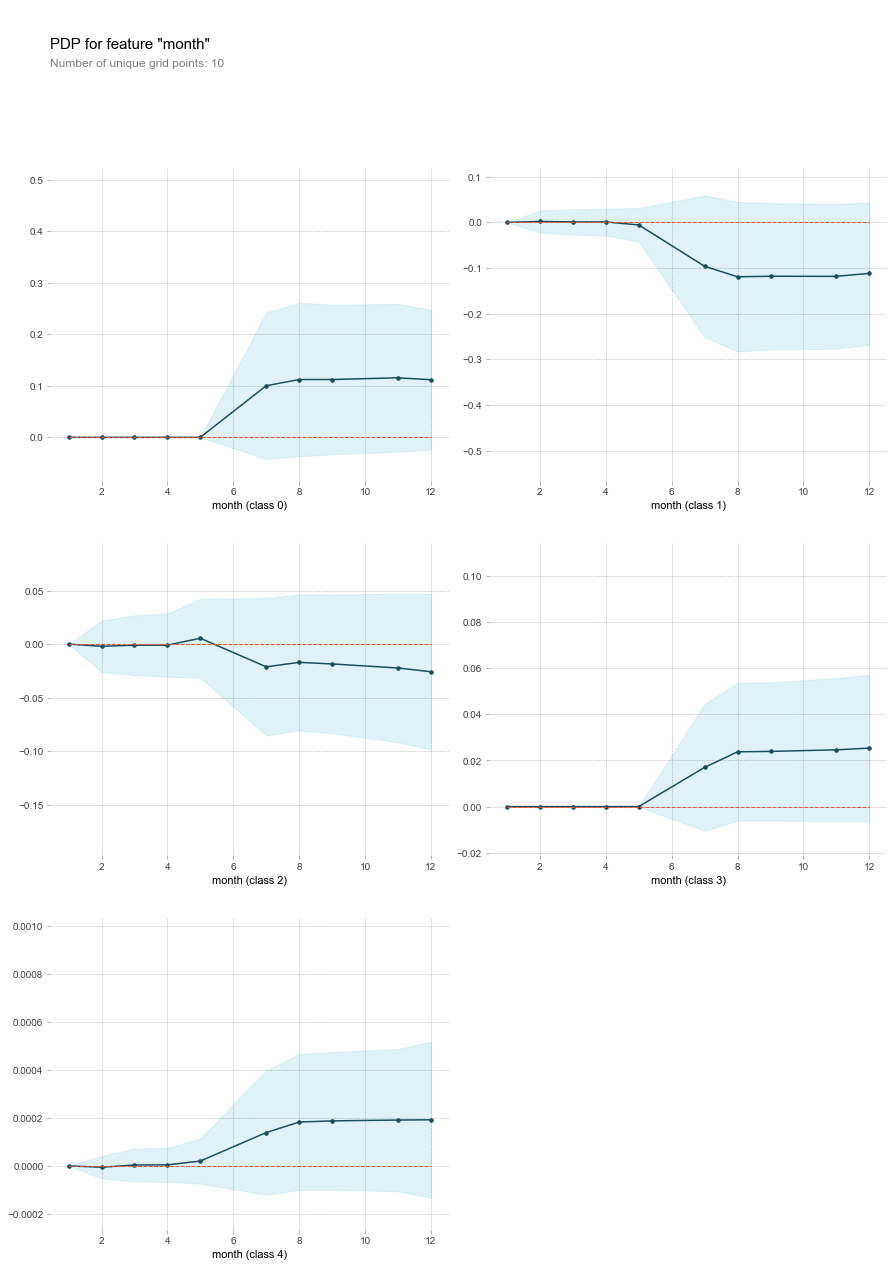

In [336]:
from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'month'

isolated = pdp_isolate(
    model=model,
    dataset=X_val_encoded,
    model_features=X_val_encoded.columns,
    feature=feature
)

pdp_plot(isolated, feature_name=feature);

In [332]:
train.head()

,problem,MDC,preRace,race,gender,lat,long,policePrecinct,neighborhood,population,...,hhIncome,poverty,collegeGrad,outcome,race_MISSING,gender_MISSING,month,day,hour,race_confusion
33578,traffic,MDC,Unknown,White,Male,44.991982,-93.217693,2,Mid - City Industrial,240.0,...,38875.0,0.067,0.568,none,False,False,9,1,22,True
50084,traffic,MDC,White,White,Female,44.905100,-93.295294,5,Lynnhurst,5934.0,...,118202.0,0.031,0.763,none,False,False,3,2,13,False
4992,suspicious,MDC,Unknown,Native American,Male,44.978210,-93.269290,1,Downtown West,7141.0,...,67086.0,0.057,0.551,none,False,False,12,5,11,True
37555,traffic,MDC,Unknown,White,Unknown,44.992669,-93.237184,2,Como,16022.0,...,67600.0,0.037,0.549,none,False,False,1,24,10,True
16288,suspicious,MDC,Unknown,Unknown,Male,44.956435,-93.294405,5,Lowry Hill East,6357.0,...,49868.0,0.066,0.569,none,False,False,7,31,13,False


In [74]:
y_val.shape

(8308,)

In [75]:
X_train.shape, X_val.shape, X_test.shape

((33228, 22), (8308, 22), (10384, 22))

In [90]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from xgboost import XGBClassifier

encoder = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='median')
)

X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)

eval_set = [(X_train_encoded, y_train),
           (X_val_encoded, y_val)]

model = XGBClassifier(n_estimators=1000, n_jobs=-1)
model.fit(X_train_encoded, y_train,
          eval_set=eval_set,
          eval_metric='auc',
          early_stopping_rounds=10)

[0]	validation_0-auc:0.733498	validation_1-auc:0.740833
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.755149	validation_1-auc:0.762664
[2]	validation_0-auc:0.755202	validation_1-auc:0.762814
[3]	validation_0-auc:0.755897	validation_1-auc:0.763071
[4]	validation_0-auc:0.760077	validation_1-auc:0.766766
[5]	validation_0-auc:0.764403	validation_1-auc:0.770106
[6]	validation_0-auc:0.764891	validation_1-auc:0.769962
[7]	validation_0-auc:0.773046	validation_1-auc:0.778436
[8]	validation_0-auc:0.78583	validation_1-auc:0.789789
[9]	validation_0-auc:0.784641	validation_1-auc:0.788923
[10]	validation_0-auc:0.79004	validation_1-auc:0.793641
[11]	validation_0-auc:0.787817	validation_1-auc:0.791974
[12]	validation_0-auc:0.791741	validation_1-auc:0.795118
[13]	validation_0-auc:0.78973	validation_1-auc:0.792837
[14]	validation_0-auc:0.791385	validation_1-auc:0.794818
[

[142]	validation_0-auc:0.831616	validation_1-auc:0.823513
[143]	validation_0-auc:0.83176	validation_1-auc:0.823533
[144]	validation_0-auc:0.831883	validation_1-auc:0.823544
[145]	validation_0-auc:0.832016	validation_1-auc:0.823465
[146]	validation_0-auc:0.832151	validation_1-auc:0.823433
[147]	validation_0-auc:0.832178	validation_1-auc:0.823441
[148]	validation_0-auc:0.83234	validation_1-auc:0.823513
[149]	validation_0-auc:0.832451	validation_1-auc:0.823542
[150]	validation_0-auc:0.832617	validation_1-auc:0.823543
[151]	validation_0-auc:0.832701	validation_1-auc:0.823634
[152]	validation_0-auc:0.832752	validation_1-auc:0.823588
[153]	validation_0-auc:0.832791	validation_1-auc:0.823634
[154]	validation_0-auc:0.832936	validation_1-auc:0.823728
[155]	validation_0-auc:0.833081	validation_1-auc:0.82375
[156]	validation_0-auc:0.833211	validation_1-auc:0.823675
[157]	validation_0-auc:0.833273	validation_1-auc:0.82374
[158]	validation_0-auc:0.833319	validation_1-auc:0.823717
[159]	validation_0

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [91]:
from sklearn.metrics import roc_auc_score
X_test_encoded = encoder.transform(X_test)
class_index = 1
y_pred_proba = model.predict_proba(X_test_encoded)[:, class_index]
print(f'Test ROC AUC for class {class_index}:')
print(roc_auc_score(y_test, y_pred_proba)) # Ranges from 0-1, higher is better

Test ROC AUC for class 1:
0.8256350267289035


In [92]:
y_pred_proba

array([0.1853826 , 0.00032824, 0.09079903, ..., 0.0312407 , 0.10957704,
       0.22292887], dtype=float32)

In [93]:
X_test.tail()

,problem,MDC,preRace,race,gender,lat,long,policePrecinct,neighborhood,population,...,foreignBorn,hhIncome,poverty,collegeGrad,race_MISSING,gender_MISSING,month,day,hour,race_confusion
39760,traffic,MDC,Unknown,White,Male,44.903546,-93.274309,3,Diamond Lake,5620.0,...,0.092,73668.0,0.050,0.531,False,False,12,2,18,True
38319,traffic,MDC,White,Black,Female,44.953616,-93.302125,5,East Isles,3261.0,...,0.087,82145.0,0.071,0.790,False,False,7,10,13,True
8747,suspicious,MDC,Unknown,Unknown,Unknown,44.984084,-93.244801,2,Marcy Holmes,10496.0,...,0.174,27104.0,0.042,0.587,False,False,2,11,19,False
49051,traffic,MDC,Unknown,White,Male,44.951887,-93.240820,3,Longfellow,4704.0,...,0.097,49378.0,0.057,0.390,False,False,5,5,22,True
12949,suspicious,MDC,East African,East African,Male,44.963327,-93.277813,5,Steven's Square - Loring Heights,3897.0,...,0.133,24783.0,0.053,0.512,False,False,5,9,0,False


In [95]:
row = X_test.loc[[8747]]
row

,problem,MDC,preRace,race,gender,lat,long,policePrecinct,neighborhood,population,...,foreignBorn,hhIncome,poverty,collegeGrad,race_MISSING,gender_MISSING,month,day,hour,race_confusion
8747,suspicious,MDC,Unknown,Unknown,Unknown,44.984084,-93.244801,2,Marcy Holmes,10496.0,...,0.174,27104.0,0.042,0.587,False,False,2,11,19,False


In [96]:
import shap

explainer = shap.TreeExplainer(model)
row_processed = encoder.transform(row)
shap_values = explainer.shap_values(row_processed)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value, 
    shap_values=shap_values, 
    features=row, 
    link='logit' 
)

In [ ]:
def explain(row_number):
    positive_class = 'other'

Assignment
Complete these tasks for your project, and document your work.

[ ] Continue to iterate on your project: data cleaning, exploratory visualization, feature engineering, modeling.
[ ] Make a Shapley force plot to explain at least 1 individual prediction.
[ ] Share at least 1 visualization (of any type) on Slack.
But, if you aren't ready to make a Shapley force plot with your own dataset today, that's okay. You can practice this objective with another dataset instead. You may choose any dataset you've worked with previously.

Stretch Goals
[ ] Make Shapley force plots to explain at least 4 individual predictions.
If your project is Binary Classification, you can do a True Positive, True Negative, False Positive, False Negative.
If your project is Regression, you can do a high prediction with low error, a low prediction with low error, a high prediction with high error, and a low prediction with high error.
[ ] Use Shapley values to display verbal explanations of individual predictions.
[ ] Use the SHAP library for other visualization types.
The SHAP repo has examples for many visualization types, including:

Force Plot, individual predictions
Force Plot, multiple predictions
Dependence Plot
Summary Plot
Summary Plot, Bar
Interaction Values
Decision Plots